In [138]:
import torch as torch
from network.metric.accuracy import acc_srcnn_tiny_radar
from network.models.classifiers.tiny_radar import TinyRadarNN
from network.models.sr_classifier.SRCnnTinyRadar import CombinedSRCNNClassifier
from network.models.super_resolution.drln import Drln
from network.models.super_resolution.srcnn import SRCnn
from network.runner import Runner
from utils.utils_paths import get_time_in_string
from utils.utils_images import Normalization
import os
import cv2
import numpy as np
from typing import Optional
import matplotlib.pyplot as plt
from scipy.fftpack import fft, fftshift, ifftshift, ifft
from functools import partial
from multiprocessing import Pool


In [122]:
from data_loader.tiny_radar_loader import tiny_radar_for_classifier


numberOfInstanceWindows = 3
lengthOfSubWindow = 32

gestures = [
        # "PinchIndex",
        # "PinchPinky",
        # "FingerSlider",
        "FingerRub",
        "SlowSwipeRL",
        "FastSwipeRL",
        # "Push",
        "Pull",
        # "PalmTilt",
        # "Circle",
        # "PalmHold",
        # "NoHand",
    ]
data_dir = "/Users/netanelblumenfeld/Desktop/data/11G/data_feat/"
data_dir1 = "/Users/netanelblumenfeld/Desktop/data/11G/data_npy/"

persons = 4
people = list(range(1, persons, 1))



In [127]:
def normalize_data(img, pix_norm: Normalization = Normalization.Range_0_1):
    EPSILON = 1e-8

    """normalize the doppler maps of tiny radar dataset"""
    if pix_norm == Normalization.NONE:
        return img
    elif pix_norm == Normalization.Range_0_1:
        return (img - np.min(img)) / (np.max(img) - np.min(img) + EPSILON)
    elif pix_norm == Normalization.Range_neg_1_1:
        return (img - np.min(img)) / (np.max(img) - np.min(img) + EPSILON) * 2 - 1
    else:
        raise ValueError("Unknown normalization type: " + str(type))

def down_sample_data_sr(
    x: np.ndarray, row_factor: int, col_factor: int, original_dim: bool = False
) -> np.ndarray:
    def _down_sample(img: np.ndarray, row_factor: int, col_factor: int) -> np.ndarray:
        return img[::row_factor, ::col_factor]

    def _up_scale(img: np.ndarray, dim_up: tuple[int, int]) -> np.ndarray:
        real_img = np.real(img)
        imag_img = np.imag(img)
        data_real_up = cv2.resize(real_img, dim_up, interpolation=cv2.INTER_CUBIC)
        data_imag_up = cv2.resize(imag_img, dim_up, interpolation=cv2.INTER_CUBIC)
        return data_real_up + 1j * data_imag_up
    assert x.ndim == 3
    if original_dim:
        res = np.empty_like(x)
        org_dim = (x.shape[3], x.shape[2])
    else:
        res = np.empty(
            (
                x.shape[0],
                x.shape[1] // row_factor,
                x.shape[2] // col_factor,
            ),
            dtype=np.complex64,
        )
    x_len = x.shape[0]
    for i in range(x_len):
        img = _down_sample(x[i], row_factor, col_factor)
        if original_dim:
            img = _up_scale(img, org_dim)

        res[i] = img
    return res

In [132]:
def data_paths(data_dir:str, people:int, gestures:list, data_type:str) -> list[str]:
    lengthOfSubWindow = 32
    if data_type == "doppler":
        folder_path = os.path.join(data_dir,'data_feat')
    elif data_type == "npy":
        folder_path = os.path.join(data_dir,'data_npy')
    else:
        raise ValueError("data type must be npy or doppler")
    data_paths = []
    for person in range(1,people):
        for gesture in gestures:
            if data_type == "npy":
                file_name = f"p{str(person)}/{gesture}_1s.npy"
            elif data_type == "doppler":
                file_name = f"p{str(person)}/{gesture}_1s_wl{lengthOfSubWindow}_doppl.npy"
            else:
                raise ValueError("data type must be npy or doppler")
            data_paths.append(os.path.join(folder_path, file_name))
    return data_paths

def load_data(data_paths:str, with_labels:bool = False) -> np.ndarray:
    #TODO: add labels   
    try:
        data = np.load(data_paths)
    except:
        raise ValueError(f"failed to load data from {data_paths}")
    if with_labels:
        pass
    return data


def npy_feat_reshape(x: np.ndarray) -> np.ndarray:
    numberOfWindows = x.shape[0]
    numberOfSweeps = x.shape[1]
    numberOfRangePoints = x.shape[2]
    numberOfSensors = x.shape[3]
    lengthOfSubWindow = 32

    numberOfSubWindows = int(numberOfSweeps / lengthOfSubWindow)

    x = x.reshape(
            (
                numberOfWindows,
                numberOfSubWindows,
                lengthOfSubWindow,
                numberOfRangePoints,
                numberOfSensors,
            )
        )
    return x

def feat_sr_reshape(x: np.ndarray) -> np.ndarray:
    """
    reshape data to fit the SR model input
    output shape is (samples*sub_windows*sensors,range_points, doppler_points)
    """
    assert x.ndim == 5, "data must be 5D"
    x_reshape = x.transpose(0, 1, 4, 2, 3)
    samples, sub_windows, sensors, range_points, doppler_points = x_reshape.shape
    x_reshape = x_reshape.reshape(samples*sub_windows*sensors,range_points, doppler_points)
    return x_reshape

def doppler_map(x: np.ndarray, ax:int = 1) -> np.ndarray:
    """input shape is (N,doppler_points,range_points)"""
    assert x.ndim == 3, "data must be 3D"
    return np.abs(fftshift(fft(x, axis=ax), axes=ax))

def normalize_sr_data(x: np.ndarray, norm:Normalization = Normalization.Range_0_1) -> np.ndarray:
    """input shape is (N,doppler_points,range_points)"""
    assert x.ndim == 3, "data must be 3D"
    x_len = x.shape[0]
    for i in range(x_len):
        x[i] = normalize_data(x[i], norm)
    return x


def load_tiny_data_sr_pipeline(path:str, norm_func, down_sample_func) -> tuple[np.ndarray, np.ndarray]:
    high_res_time = load_data(path)
    high_res_time = feat_sr_reshape(npy_feat_reshape(high_res_time))
    low_res_time = down_sample_func(high_res_time)
    high_res = doppler_map(high_res_time)
    high_res = norm_func(high_res)
    low_res = doppler_map(low_res_time)
    low_res = norm_func(low_res)
    return low_res, high_res

data_dir = "/Users/netanelblumenfeld/Desktop/data/11G/"

res = data_paths(data_dir, 4, gestures, "npy")
ds_func = partial(down_sample_data_sr, row_factor=4, col_factor=4, original_dim=False)
norm_func = partial(normalize_data, pix_norm=Normalization.Range_0_1)
img = load_tiny_data_sr_pipeline(res[0], norm_func, ds_func)

In [139]:
def load_tiny_data_sr(data_dir:str, people:int, gestures:list, data_type:str) -> list[np.ndarray]:
    res = data_paths(data_dir, people, gestures, data_type)
    ds_func = partial(down_sample_data_sr, row_factor=4, col_factor=4, original_dim=False)
    norm_func = partial(normalize_data, pix_norm=Normalization.Range_0_1)
    num_workers = os.cpu_count()
    print(f"down sampling data with {num_workers} cpus")
    with Pool(num_workers) as p:
        load_data_func = partial(load_tiny_data_sr_pipeline, norm_func=norm_func, down_sample_func=ds_func)
        data = p.map(load_data_func, res)
    return data
res = load_tiny_data_sr(data_dir, 4, gestures, "npy")

down sampling data with 8 cpus


Process SpawnPoolWorker-25:
Process SpawnPoolWorker-26:
Process SpawnPoolWorker-28:
Process SpawnPoolWorker-27:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniconda/base/envs/radar/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniconda/base/envs/radar/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/opt/homebrew/Caskroom/miniconda/base/envs/radar/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/opt/homebrew/Caskroom/miniconda/base/envs/radar/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/homebrew/Caskroom/miniconda/base/envs/radar/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/opt/homebrew/Caskroo

KeyboardInterrupt: 

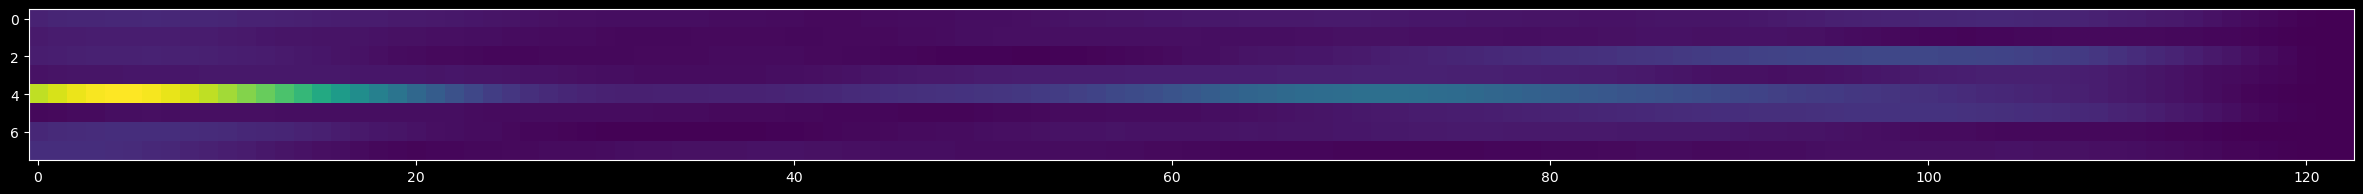

In [135]:
# img_semp = doppler_map(img[0])
plt.figure(figsize=(30,30))

plt.imshow(img[0][0])

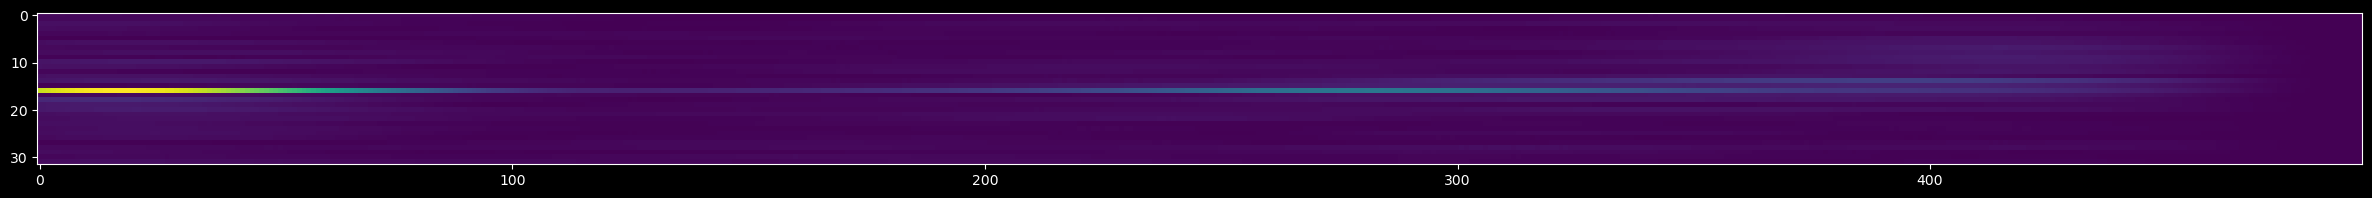

In [137]:
plt.figure(figsize=(30,30))

plt.imshow(img[1][0])